# Google Colaboratory の準備

本ファイルは、`notebook/1-5_single_inference.ipynb`をGoogle Colaboratoryで実行するためのノートブックです。  
あらかじめ、`notebook/colab/1-0_prepare_colab.ipynb`の手順を実行し、Googleドライブにリファレンス環境（ソフトウェア）のリポジトリとデータセット・学習済みモデルの準備が完了していることを確認してください。

## GPUの指定

Google Colaboratoryのメニューバーの「ランタイム」から「ランタイムのタイプを変更」を選択し、
ハードウェア アクセラレータを**GPU**に指定した上で、本ファイルを実行してください。

## ライブラリのインストール

In [ ]:
!pip install -q torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q nuscenes-devkit

!pip install -q fire tensorboardX protobuf opencv-python
!pip install -q numba scikit-image scipy pillow

     |███████████████████████         | 834.1 MB 50.3 MB/s eta 0:00:07tcmalloc: large alloc 1147494400 bytes == 0x3a520000 @  0x7f765a343615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:26tcmalloc: large alloc 1434370048 bytes == 0x7eb76000 @  0x7f765a343615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 1156.7 MB 1.2 MB/s eta 0:00:01tcmalloc: large alloc 1445945344 bytes == 0xd4362000 @  0x7f765a343615 0x592b76 0x4df71e 0x59afff 0x515655 0

In [ ]:
# spconv v1.2.1 のインストール

!git clone --depth 1 --recursive  -b v1.2.1 https://github.com/traveller59/spconv.git
%cd spconv
!SPCONV_FORCE_BUILD_CUDA=1 python setup.py bdist_wheel
!pip install ./dist/spconv*

Cloning into 'spconv'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 118 (delta 16), reused 33 (delta 1), pack-reused 0
Receiving objects: 100% (118/118), 234.67 KiB | 7.33 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Submodule 'third_party/cutlass' (https://github.com/NVIDIA/cutlass) registered for path 'third_party/cutlass'
Submodule 'third_party/mp11' (https://github.com/boostorg/mp11) registered for path 'third_party/mp11'
Submodule 'third_party/pybind11' (https://github.com/pybind/pybind11.git) registered for path 'third_party/pybind11'
Cloning into '/content/spconv/third_party/cutlass'...
remote: Enumerating objects: 16512, done.        
remote: Counting objects: 100% (567/567), done.        
remote: Compressing objects: 100% (297/297), done.        
remote: Total 16512 (delta 257), reused 529 (delta 249), pack-reused 15945        
Receiving objects: 100% (16512/1651

## Googleドライブをマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# WORK_DIRのパスは自身の作業ディレクトリに変更してください。

WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/work/"
%cd $WORK_DIR

# パスを合わせるため、リポジトリのnotebookディレクトリに移動
%cd ./6th-ai-reference2/notebook

/content/drive/MyDrive/Colab Notebooks/work
/content/drive/MyDrive/Colab Notebooks/work/6th-ai-reference2/notebook


以下より、`notebook/1-5_single_inference.ipynb`と同じ内容です。

# 概要

本ファイルでは、データセットの1インスタンスに対して、PointPaintingによる推論を実施します。  
PointPaintingの一連の処理を確認できます。

PointPaintingは、次の3ステップで実行します。

1. セマンティックセグメンテーション  
カメラ画像に対してセマンティックセグメンテーションを行い、各ピクセルのセグメンテーションスコアを取得


2. 融合 (点群のペインティング)  
算出したセグメンテーション結果をLidarの点群データに結合し、拡張点群データを作成


3. 3D物体検出  
拡張点群データを入力として、3D物体検出モデルで推論し、3Dバウンディングボックスを取得

# 準備

あらかじめ、 `data`ディレクトリに`3d_labels`、および、`second.pytorch/checkpoints/{model_dir}`ディレクトリに学習済みモデルがあることを確認してください。

> 本ファイルのデフォルトでは、公開の学習済みモデル`second.pytorch/checkpoints/pointpainting`を設定しています。

```
└ data
    ├ 3d_labels
        ├ maps
        ├ samples
            ├ CAM_FRONT
            └ LIDAR_TOP
        └ v1.0-trainval

├second.pytorch
     └ checkpoints
        └ {model_dir}
            ├ checkpoints.json
            ├ {model-step}.tckpt <- 学習済みモデル

```

## ライブラリのインポート

In [ ]:
import copy
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline

import cv2
import torch
from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import LidarPointCloud
from pyquaternion import Quaternion
from torchvision import transforms

from utils.box_plot import boxes_to_corners_3d, cv2_draw_3d_bbox
from utils.calibration_nuscenes import (get_image_points, lidar_to_cam,
                                        lidar_to_global)
from utils.detector import Second3DDector
from utils.pointcloud_seg import (get_segmentation_score,
                                  map_pointcloud_to_image, overlap_seg)
from utils.vis_pointcloud import (get_figure_data, view_pointcloud,
                                  view_pointcloud_3dbbox)

## 読み込みファイルのパス設定

In [ ]:
dataset_path = "../data/3d_labels"

# シーンIDとフレームIDの選択
scene_id = 29
frame_id = 73

# 物体検知モデル
config_path = "../second.pytorch/second/configs/nuscenes/pointpainting.config"
ckpt_path = "../second.pytorch/checkpoints/pointpainting/voxelnet-24000.tckpt"

## datasetの読み込み

In [ ]:
nusc = NuScenes(version='v1.0-trainval', dataroot=dataset_path, verbose=True)

assert scene_id < len(nusc.scene), \
     f"SceneIDの指定値:{scene_id}が総シーン数:{len(nusc.scene)}を超えています。"

target_scene = nusc.scene[scene_id]
print(f"SceneID: {scene_id}")
print(f"  総フレーム数: {target_scene['nbr_samples']}")
print(f"FrameID: {frame_id}")

assert frame_id < target_scene["nbr_samples"], \
     f"FrameIDの指定値:{frame_id}がフレーム数:{target_scene['nbr_samples']}を超えています。"

sample_token = target_scene['first_sample_token']

for i in range(frame_id):
    sample = nusc.get('sample', sample_token)
    sample_token = sample['next']

sample_record = nusc.get('sample', sample_token)

test_key = f"{target_scene['name']}_{frame_id:0>2}"
print(f"test_key: {test_key}")

Loading NuScenes tables for version v1.0-trainval...
20 category,
8 attribute,
4 visibility,
2176 instance,
2 sensor,
74 calibrated_sensor,
2475 ego_pose,
37 log,
37 scene,
2475 sample,
4950 sample_data,
42142 sample_annotation,
37 map,
Done loading in 7.995 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.
SceneID: 29
  総フレーム数: 183
FrameID: 73
test_key: scene-0109_73


In [ ]:
# LidarとCamのtokenを取得
pointsensor_token = sample_record['data']['LIDAR_TOP']
camera_token = sample_record['data']['CAM_FRONT']
# LidarとCamのレコードを取得
pointsensor = nusc.get('sample_data', pointsensor_token)
cam = nusc.get('sample_data', camera_token)

# inputデータの形式で各メタ情報を取得
cam_path = os.path.join(nusc.dataroot, cam['filename'])
lidar_path = os.path.join(nusc.dataroot, pointsensor['filename'])
cam_ego_pose = nusc.get('ego_pose', cam['ego_pose_token'])
cam_calibration = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
lidar_ego_pose = nusc.get('ego_pose', pointsensor['ego_pose_token'])
lidar_calibration = nusc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])

# 1. セグメンテーション

第1ステップでは、カメラ画像に対して、セマンティックセグメンテーションを実行し、ピクセルごとのセグメンテーションスコアを取得します。

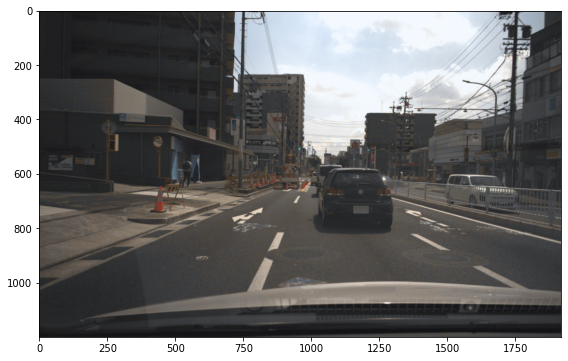

In [ ]:
# 入力画像の確認
img = Image.open(cam_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)

## セグメンテーションモデルの定義

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# 学習済みのdeeplabv3モデルをロード
model_seg = torch.hub.load('pytorch/vision:v0.6.0',
                           'deeplabv3_resnet101', pretrained=True)
model_seg.eval()
model_seg.to(device)

print("Segmentation Model Loaded.")

Using cuda device


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Segmentation Model Loaded.


## セグメンテーションモデルの推論

今回のモデルの推論で出力されるスコアは、次の3クラスです。

1. background
2. car
3. person

In [ ]:
class_scores = get_segmentation_score(cam_path, model_seg, device)

print("class_scores shape: ", class_scores.shape)  # (H, W, C)

class_scores shape:  (1200, 1920, 3)


# 2. 融合 (点群のペインティング) 

セグメンテーションスコアを点群に投影し、点群の次元にセグメンテーションスコアを追加することで拡張点群を取得します。  
点群の次元は (x, y, z, r) から (x, y, z, r, C1, C2, C3) へ拡張されます。

In [ ]:
# Lidar点群を画像に投影して画像座標を取得
points_mask, points_image = map_pointcloud_to_image(cam_path,
                                                    lidar_path,
                                                    cam_ego_pose,
                                                    lidar_ego_pose,
                                                    cam_calibration,
                                                    lidar_calibration)

print("points_mask", points_mask.shape)   # 画像範囲でマスク処理した点群 (N, pcd_dim)
print("points_image", points_image.shape) # (N, 2)  2:カメラ画像のx,y軸

points_mask (39581, 4)
points_image (39581, 2)


In [ ]:
# 点群データとセグメンテーションを結合し、拡張点群データを作成
class_num = class_scores.shape[2]

# points_image は x,y が画像座標で、cols, rows であるのに対し、
# class_score は (rows, cols) なので、以下のインデックスの値は 1 → 0 と逆になる
point_scores = class_scores[points_image[:, 1], points_image[:, 0]]
point_scores = point_scores.reshape(-1, class_num)

print(point_scores.shape)  # (N, class_num)

(39581, 3)


In [ ]:
painted_lidar = np.hstack([points_mask, point_scores])
painted_lidar = painted_lidar.astype(np.float32)

print(painted_lidar.shape)  # (N, pcd_dim + class_num)

(39581, 7)


## 可視化

### セグメンテーション + 画像

セグメンテーション結果を画像にオーバーラップして表示します。

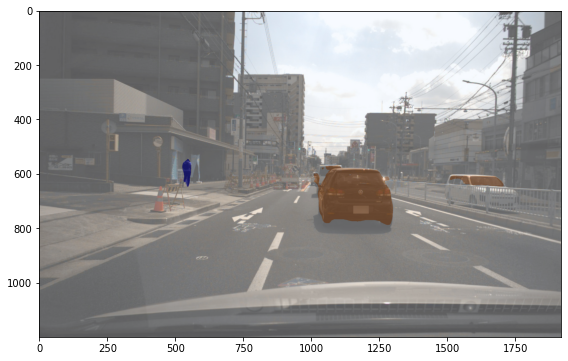

In [ ]:
img = Image.open(cam_path)
img_np = np.array(img)

img_seg = overlap_seg(img_np,
                      class_scores,
                      opacity=0.3)

plt.figure(figsize=(10, 6))
plt.imshow(img_seg)

### セグメンテーション + 点群

点群とセグメンテーション結果を結合した拡張点群を3D散布図に表示します。

In [ ]:
pc_data = painted_lidar[::4]  # 可視化処理の軽減のため1/4にデータ間引き

# 拡張点群のセグメンテーションの色
segcolor_dict = {0: "darkgray",  # background
                 1: "orange",    # car
                 2: "blue"}      # person

points_xyz = pc_data[:, :3]  # (x, y, z)を抽出
points_class = np.argmax(pc_data[:, 4:], axis=1)  # Classを抽出
points_colors = [segcolor_dict[i] for i in points_class]

fig = view_pointcloud(points_xyz, points_colors, mode="front")
fig.show()

# 3. 3D物体検出

拡張点群から3D物体検出を行います。

### 3D物体検出モデルの定義

In [ ]:
model_detector = Second3DDector(config_path,
                                ckpt_path,
                                device=device)

[  41 1984  992]


In [ ]:
pred_dict = model_detector.predict_on_points(painted_lidar)

print(pred_dict.keys())
print(pred_dict["boxes_lidar"].shape) # 3Dバウンディングボックス (N, 7)

# 3Dバウンディングボックスの推論結果
print(pred_dict["boxes_lidar"])    # [x, y, z, w, l, h, rz]
print(pred_dict["scores"])
print(pred_dict["label_preds"])    #  0: car, 1: pedestrian

dict_keys(['boxes_lidar', 'scores', 'label_preds'])
(4, 7)
[[11.213233   -0.5890917  -1.0906528   1.693042    3.79752     1.7685262
   1.5032802 ]
 [22.525846    8.26645    -0.25483683  0.5534073   0.73252857  1.6650045
   0.99958587]
 [18.735128   -7.0229278  -1.3666798   1.7607186   4.176951    1.6236247
  -1.5821984 ]
 [25.032726   -0.5839502  -0.87462395  1.8508977   4.609808    1.724199
   1.6355377 ]]
[0.8041243  0.65975964 0.64905804 0.58988243]
[0 1 0 0]


## 可視化

### カメラ画像

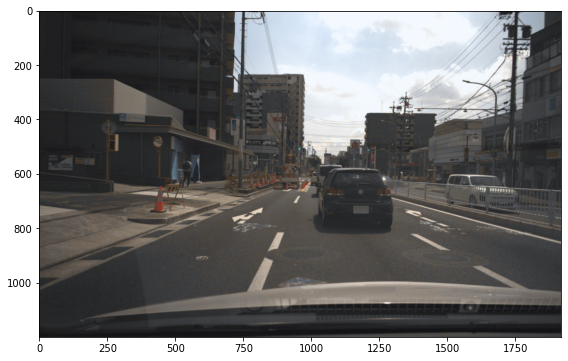

In [ ]:
img = Image.open(cam_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)

### 3Dバウンディングボックス + 画像

3Dバウンディングボックスを画像にオーバーラップして表示します。

In [ ]:
# 3Dバウンディングボックスの各頂点座標を取得 (N, 7) -> (N, 8, 3)
box_corners = boxes_to_corners_3d(pred_dict["boxes_lidar"])
labels = pred_dict["label_preds"]

print(box_corners.shape) # 3DBBox各頂点のxyz座標 (N, 8, 3)

(4, 8, 3)


In [ ]:
# Lidar座標系 -> カメラ座標系 に変換
box_corners_cam = lidar_to_cam(box_corners.reshape(-1, 3),
                        cam_ego_pose,
                        lidar_ego_pose,
                        cam_calibration,
                        lidar_calibration)

# 点群を画像へ投影し画像上の座標を取得
projection = np.array(cam_calibration['camera_intrinsic'])
box_corners_img = get_image_points(box_corners_cam[:, :3], projection) # (N, 3)

box_corners_img = box_corners_img[:, :2]             # (N * 8, 2)
box_corners_img = box_corners_img.reshape(-1, 8, 2)  # (N, 8, 2)

print(box_corners_img.shape)

(4, 8, 2)


In [ ]:
name_list = model_detector.target_assigner.classes
label_name_dict = {i : name  for i, name in enumerate(name_list)}
print(label_name_dict)

{0: 'car', 1: 'pedestrian'}


In [ ]:
color_dict_label = {0: (253, 141, 60),   # car:        orange
                    1: (0, 0, 255),      # pedestrian: blue    
                    }

box_colors = [color_dict_label[label] for label in labels]

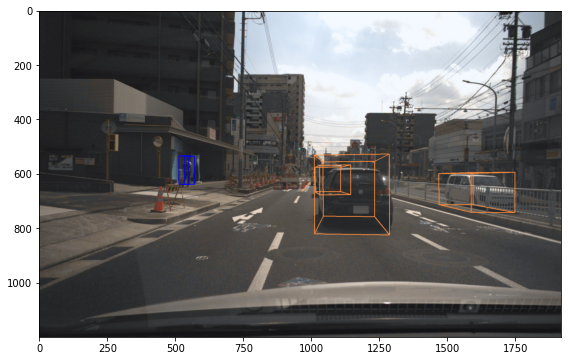

In [ ]:
# 画像をOpenCVで読み込み
img_cv = cv2.imread(cam_path)
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# 3Dバウンディングボックス+画像を表示
img_cv_box = cv2_draw_3d_bbox(img_cv, box_corners_img,
                              box_colors, thickness=2, line_type=cv2.LINE_8)

plt.figure(figsize=(10, 6))
plt.imshow(img_cv_box)

### 3Dバウンディングボックス + 点群

点群と3Dバウンディングボックスを3D散布図に表示します。

In [ ]:
# 点群
fig = view_pointcloud_3dbbox(points_xyz, points_colors, box_corners, box_colors)

fig.show()

# 推論結果を辞書形式に変換

3Dバウンディングボックスの推論結果を辞書形式に変換します。  
    （投稿ファイルの`predictor.py`のpredictメソッドの返り値と同じ形式です。）  

1. 3DバウンディングボックスをLidar座標からグローバル座標へ変換
2. 自車からの距離が指定範囲のものを検出対象とし、辞書形式に変換

In [ ]:
# 3Dバウンディングボックスの中心座標 
points_box = pred_dict["boxes_lidar"][:, :3]  # (N, 3)  3: [x, y, z]

# Lidar座標系 -> グローバル座標系 に変換
points_box_global = lidar_to_global(points_box,
                                    lidar_ego_pose,
                                    lidar_calibration)

print(points_box_global.shape)   # (N, 3)

(4, 3)


In [ ]:
list_pedestrian = []
list_vehicle = []

for pred, label, score in zip(points_box_global[:, :2],
                                pred_dict["label_preds"],
                                pred_dict["scores"].astype(np.float64)):
    # 自車からの距離
    dist = np.linalg.norm(pred - np.array(lidar_ego_pose['translation'][:2]))
    
    # 指定の距離以内を検出対象に加える
    if label_name_dict[label] == "pedestrian":
        if dist <= 40:
            list_pedestrian.append(list(pred) + [score])
    elif label_name_dict[label] == "car":
        if dist <= 50:
            list_vehicle.append(list(pred) + [score])

# 各カテゴリーの数を50以下に制限
list_pedestrian = list_pedestrian[:50]
list_vehicle = list_vehicle[:50]

prediction = {}
if len(list_pedestrian) > 0 :
    prediction["pedestrian"] = list_pedestrian
if len(list_vehicle) > 0 :
    prediction["vehicle"] = list_vehicle

output = {test_key: prediction}

print(output)

{'scene-0109_73': {'pedestrian': [[276.9118382023977, 217.7714512798479, 0.6597596406936646]], 'vehicle': [[265.21548774794775, 209.43282420226507, 0.8041242957115173], [272.4437801829357, 202.6737879340508, 0.6490580439567566], [279.0220425565739, 208.82328485920917, 0.5898824334144592]]}}


以上